# rf 0620

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [2]:
fog_train = pd.read_csv('/Users/yunkihun/weather-contest/weather-contest/fog_python/fog_train.csv')
fog_test = pd.read_csv('/Users/yunkihun/weather-contest/weather-contest/fog_python/fog_test.csv')

In [3]:
# eda 함수 전처리

df = fog_train.drop(columns=[ 
                "Unnamed: 0",
                "fog_train.year", 
                #"fog_train.month", 
                "fog_train.day",
                #"fog_train.time",
                "fog_train.minute",
                "fog_train.vis1",
                ])

df = df.replace(-99.00, np.NaN)
df = df.replace(-99.90, np.NaN)

columns = df.columns
columns = [column.replace('fog_train.', "") for column in columns]
df.columns = columns


df = df.dropna()

def stn_transform(value):
    if value.startswith("A"):
        return 1
    elif value.startswith("B"):
        return 2
    elif value.startswith("C"):
        return 3
    elif value.startswith("D"):
        return 4
    elif value.startswith("E"):
        return 5
    
df["stn_id"] = df["stn_id"].apply(stn_transform)
df["temp_diff"] = df["ta"] - df["ts"]
df = df[df['hm'] != 0]
df.loc[df['ws10_deg'] == 360, 'ws10_deg'] = 0

df.shape

(2994849, 12)

In [4]:
# 이슬점
def calculate_dew_point(T, RH):
    a = 17.27
    b = 237.7
    gamma = (a * T) / (b + T) + np.log(RH / 100.0)
    dew_point = (b * gamma) / (a - gamma)
    return dew_point

df['dew_point'] = calculate_dew_point(df['ta'], df['hm'])

dew_re_list = []
for i in range(len(df)):
    if df['ts'].values[i] < df['dew_point'].values[i]:
        dew_re_list.append(1)
    else:
        dew_re_list.append(0)
df['dew_reached'] = dew_re_list
df = df.drop(columns=['dew_point'])
df.shape

(2994849, 13)

In [5]:
# 이상치 제거
mean = df['temp_diff'].mean()
std = df['temp_diff'].std()

condition = (df['temp_diff'] <= (mean + 2 * std)) & (df['temp_diff'] >= (mean - 2 * std))
print("이상치 점 샘플 수", df.shape)

df = df[condition]
print("이상치 제거하고 남은 샘플 수", df[condition].shape)

이상치 점 샘플 수 (2994849, 13)
이상치 제거하고 남은 샘플 수 (2826124, 13)


/var/folders/ld/bjk749657q3gc2fpmc3lht4m0000gn/T/ipykernel_39240/2267321007.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("이상치 제거하고 남은 샘플 수", df[condition].shape)


In [6]:
# CM 함수
def csi_index(cm):

     H = (cm[0][0] + cm[1][1] + cm[2][2])
     F = (cm[0][1] + cm[0][2] + 
          cm[1][0] + cm[1][2] + 
          cm[2][0] + cm[2][1] +
          cm[3][0] + cm[3][1] + cm[3][2])
     M = (cm[0][3] + cm[1][3] + cm[2][3])

     knn_csi = H / (H + F + M)
     return knn_csi

In [7]:
# feature importances 함수
def feature_importances(model, df):
    importances = model.feature_importances_
    feature_columns = list(df.columns.difference(["class"]))
    column_nm = pd.DataFrame(feature_columns)
    feature_importances = pd.concat([column_nm, pd.DataFrame(importances)], axis=1)
    feature_importances.columns=['feature_nm', 'importances']
    print(feature_importances)

In [8]:
# random forest 함수

def random_forest(df):
    feature_columns = list(df.columns.difference(["class"]))
    X = df[feature_columns]
    y=df["class"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
    
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    
    rf_model.fit(X_train, y_train)
    
    y_pred = rf_model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(csi_index(cm))
    
    feature_importances(rf_model,df)

In [59]:
# 5hr change 함수
def fivehr(df):
    df['5hr_chg'] = df['ta'] - df['ta'].shift(5)

# basic

In [41]:
df

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,dew_reached
0,1,0,1,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,-3.6,0
1,1,0,1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,-3.6,0
2,1,0,1,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,-3.7,0
3,1,0,1,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,-3.6,0
4,1,0,1,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,-3.6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,5,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0
3156455,12,23,5,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0
3156456,12,23,5,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,0
3156457,12,23,5,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,0


In [55]:
random_forest(df)

[[   865    242     18    824]
 [   208   1053    172   1551]
 [    19    225    406   2329]
 [    23    108    196 698292]]
0.2820730671197961
     feature_nm  importances
0   dew_reached     0.003776
1            hm     0.155237
2         month     0.055993
3            re     0.007984
4        stn_id     0.035365
5         sun10     0.037815
6            ta     0.139087
7     temp_diff     0.120774
8          time     0.081490
9            ts     0.133041
10     ws10_deg     0.136419
11      ws10_ms     0.093020


In [62]:
# 5hr change 추가
fivehr(df)
df = df.iloc[5:]

In [64]:
random_forest(df)

[[   827    226     17    879]
 [   192   1031    135   1626]
 [    13    208    397   2361]
 [    15     94    171 698338]]
0.2752685546875
     feature_nm  importances
0       5hr_chg     0.084568
1   dew_reached     0.003754
2            hm     0.146688
3         month     0.053378
4            re     0.006940
5        stn_id     0.033683
6         sun10     0.032207
7            ta     0.125969
8     temp_diff     0.113176
9          time     0.073462
10           ts     0.121207
11     ws10_deg     0.120659
12      ws10_ms     0.084310


In [9]:
# stn_id 원 핫 인코딩
for i in range(5):
    df[f'''stn_{['A', 'B', 'C', 'D', 'E'][i]}'''] = df['stn_id'].apply(
        lambda x: 1 if x == i + 1 else 0
    )
    
df = df.drop(columns=["stn_id"])

In [10]:
df

,month,time,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,dew_reached,stn_A,stn_B,stn_C,stn_D,stn_E
0,1,0,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,-3.6,0,1,0,0,0,0
1,1,0,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,-3.6,0,1,0,0,0,0
2,1,0,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,-3.7,0,1,0,0,0,0
3,1,0,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,-3.6,0,1,0,0,0,0
4,1,0,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,-3.6,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0,0,0,0,0,1
3156455,12,23,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0,0,0,0,0,1
3156456,12,23,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,0,0,0,0,0,1
3156457,12,23,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,0,0,0,0,0,1


In [93]:
# 원핫인코딩 + 5hr change 없는 버전
random_forest(df)

[[   894    249     17    789]
 [   209   1121    157   1497]
 [    16    239    446   2278]
 [    26    123    209 698261]]
0.29758162031438934
     feature_nm  importances
0   dew_reached     0.004019
1            hm     0.156443
2         month     0.057323
3            re     0.007460
4         stn_A     0.005311
5         stn_B     0.009162
6         stn_C     0.002222
7         stn_D     0.005850
8         stn_E     0.003874
9         sun10     0.038411
10           ta     0.138853
11    temp_diff     0.124620
12         time     0.084182
13           ts     0.133591
14     ws10_deg     0.133784
15      ws10_ms     0.094896


In [94]:
# 원핫인코딩 + 5hr change 있는 버전
fivehr(df)
df = df.iloc[5:]

In [95]:
random_forest(df)

[[   874    229     18    828]
 [   199   1075    159   1551]
 [    17    214    414   2334]
 [    18    101    172 698327]]
0.28806534194806777
     feature_nm  importances
0       5hr_chg     0.084364
1   dew_reached     0.004002
2            hm     0.146055
3         month     0.054727
4            re     0.007699
5         stn_A     0.005740
6         stn_B     0.011077
7         stn_C     0.002359
8         stn_D     0.006024
9         stn_E     0.003939
10        sun10     0.032555
11           ta     0.126705
12    temp_diff     0.114237
13         time     0.074437
14           ts     0.122637
15     ws10_deg     0.118852
16      ws10_ms     0.084591


# 과대표집

In [11]:
df 
# 원핫인코딩 + basic

,month,time,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,temp_diff,dew_reached,stn_A,stn_B,stn_C,stn_D,stn_E
0,1,0,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,4.0,-3.6,0,1,0,0,0,0
1,1,0,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,4.0,-3.6,0,1,0,0,0,0
2,1,0,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,4.0,-3.7,0,1,0,0,0,0
3,1,0,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,4.0,-3.6,0,1,0,0,0,0
4,1,0,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,4.0,-3.6,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156454,12,23,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,4.0,3.4,0,0,0,0,0,1
3156455,12,23,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,4.0,3.6,0,0,0,0,0,1
3156456,12,23,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,4.0,3.6,0,0,0,0,0,1
3156457,12,23,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,4.0,3.7,0,0,0,0,0,1


In [12]:
feature_columns = list(df.columns.difference(["class"]))
X = df[feature_columns]
y=df["class"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

In [14]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train,y_train)
print('Resampled dataset shape :', Counter(y_res))

Resampled dataset shape : Counter({4.0: 2095856, 2.0: 2095856, 3.0: 2095856, 1.0: 2095856})


In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_res, y_res)

RandomForestClassifier(random_state=42)

In [16]:
y_pred = rf_model.predict(X_test)

In [17]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.99


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.62      0.57      0.59      1949
         2.0       0.45      0.50      0.47      2984
         3.0       0.34      0.29      0.31      2979
         4.0       1.00      1.00      1.00    698619

    accuracy                           0.99    706531
   macro avg       0.60      0.59      0.59    706531
weighted avg       0.99      0.99      0.99    706531



In [19]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

csi_index(cm)

[[  1104    379     65    401]
 [   315   1486    405    778]
 [    61    421    864   1633]
 [   302    988   1184 696145]]


0.3325630656653187

In [20]:
with open(f'''random_forest_{datetime.now().strftime('%Y%m%d%H%M%S')}.pkl''', 'wb') as file:
  pickle.dump(rf_model, file)

# 혹시 몰라 보는 vis1..

<Axes: xlabel='hm', ylabel='vis1'>

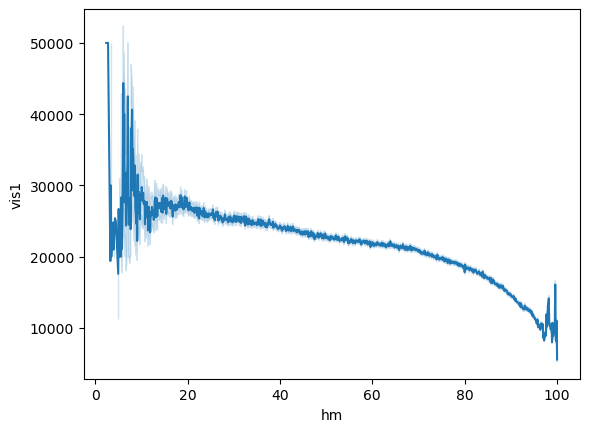

In [116]:
sns.lineplot(x='hm',y='vis1',data=df)

In [127]:
df.loc[df['class'] !=4].sort_values('hm')

,month,time,stn_id,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,vis1,class,temp_diff
18516,5,14,1,217.2,2.1,26.9,0.0,13.4,0.50,51.4,31.0,1.0,-24.5
1438613,4,12,1,84.0,2.5,19.9,0.0,16.4,0.59,36.8,946.0,3.0,-16.9
384992,4,14,1,280.6,4.8,12.8,0.0,17.3,0.50,24.1,100.0,1.0,-11.3
1438163,4,9,1,106.9,2.3,19.8,0.0,17.8,0.14,19.6,944.0,3.0,0.2
2278280,4,12,1,329.1,2.7,19.9,0.0,18.0,0.57,33.4,4.0,1.0,-13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601378,6,6,2,137.3,0.5,14.5,0.0,100.0,0.02,17.8,241.0,2.0,-3.3
2601377,6,6,2,142.9,0.4,14.1,0.0,100.0,0.03,17.6,323.0,2.0,-3.5
2601376,6,6,2,101.2,0.0,14.1,0.0,100.0,0.02,17.2,180.0,1.0,-3.1
2130289,6,19,1,203.3,5.8,23.6,1.0,100.0,0.00,22.9,360.0,2.0,0.7
